In [ ]:
# default_exp samplers.protocol_samplers

# Protocol Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction protocols

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition, make_hash, unpack
from qsam.fault_generators import Depolar
from qsam.protocol import iterate
from qsam.samplers.sampler_mixins import SubsetAnalytics

import numpy as np
from flexdict import FlexDict

In [ ]:
#export
ONE_QUBIT_GATES = {'H', 'X', 'Z'}
TWO_QUBIT_GATES = {'CNOT'}

GATE_GROUPS = {'p': ONE_QUBIT_GATES | TWO_QUBIT_GATES,
               'p1': ONE_QUBIT_GATES,
               'p2': TWO_QUBIT_GATES,
               }

In [ ]:
#export
class Sampler:
    def __init__(self, protocol, simulator):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))
                         
    def run(self, n_samples, sample_range, err_params, var=math.Wilson_var, eval_fns=None, verbose=False):

        fail_cnts = np.zeros(len(sample_range)) # one fail counter per sample point
        partitions = {circuit_hash: [partition(circuit, GATE_GROUPS[k]) for k in err_params.keys()]
                     for circuit_hash, circuit in self.protocol._circuits.items()}
                
        for i,sample_pt in enumerate(sample_range): # n_samples at sample_pt
            
            p_phy = np.array(list(err_params.values())) * sample_pt
            
            for j in range(n_samples):
                
                sim = self.simulator(self.n_qubits)
                p_it = iterate(self.protocol, eval_fns)
                node = next(p_it)
                
                if verbose: print(f'--- Protocol run {j:06d} ---')
                
                while node:
                    
                    if node == 'EXIT':
                        fail_cnts[i] += 1
                        break
                    else:
                        circuit_hash, circuit = self.protocol.circuit_from_node(node)
                        if circuit._noisy:
                            circuit_partitions = partitions[circuit_hash]
                            faults = Depolar.faults_from_probs(circuit_partitions, p_phy)
                            fault_circuit = Depolar.gen_circuit(len(circuit), faults)
                            msmt = sim.run(circuit, fault_circuit)
                        else:
                            msmt = sim.run(circuit)
                        _node = node
                        node = p_it.send(msmt)
                        if verbose:
                            msmt_str = msmt if msmt==None else f'{msmt:07b}'
                            pauli_faults = [] if not circuit._noisy else [f'Tick {tick} :: {fault_circuit[tick]}' for tick,_ in faults]
                            print(f"Node {_node}, Faults {pauli_faults}, Measured {msmt_str}-> {node}")
                    
        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std

We are going to test the direct Monte Carlo sampler on the simple GHZ state preparation flag circuit. 

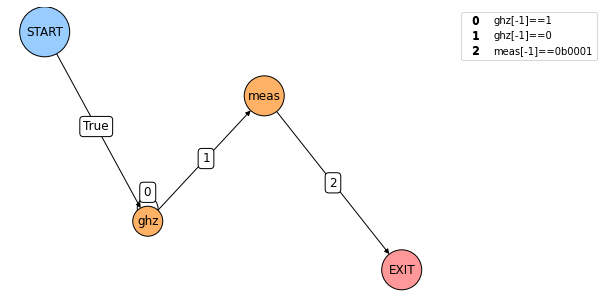

In [ ]:
from qsam.protocol import Protocol, draw_protocol, iterate
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}])

meas = Circuit([ {"measure": {0,1,2,3}} ])

ghz1 = Protocol()
ghz1.add_nodes_from(['ghz', 'meas'], circuits=[ghz,meas])
ghz1.add_edge('START', 'ghz', check='True')
ghz1.add_edge('ghz', 'ghz', check='ghz[-1]==1')
ghz1.add_edge('ghz', 'meas', check='ghz[-1]==0')
ghz1.add_edge('meas', 'EXIT', check='meas[-1]==0b0001')
draw_protocol(ghz1, figsize=(6,4), self_loop_offset=(0,0.18))

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}

sam = Sampler(ghz1, CHP)
p_L, std = sam.run(10000, sample_range, err_params)

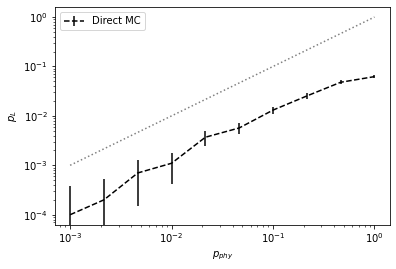

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

p = sample_range

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$p_L$')
plt.xlabel(r'$p_{phy}$')
plt.legend();

In [ ]:
show_doc(Sampler)

<h2 id="Sampler" class="doc_header"><code>class</code> <code>Sampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Sampler</code>(**`protocol`**, **`simulator`**)



For the `SubsetSampler` we want to sample from specific fault-weight-subsets upto a certain maximum weight $w_{max}$. The benefit of this approach is that we can scale each of the resulting failure rates by analytically calculated `subset_occurances` for each `p_phy` which then gives us `p_L(p_phy)` for all `p_phy` without any additional sampling required. The subset sampler chooses the next fault-weight subset that is used when sampling from the next circuit in the protocol by the minimum sampled subset for a given circuit, which results in a balanced sampling over all subsets for a circuit. Additionally, one can exclude sampling for all circuits in a protocol from certain subsets by specifying a *list of ints* of `w_exclude` fault-weights. Overall, this approach of choosing the subsets and defining the weight threshold is not ideal. The dynamic subset sampler includes methods to improve on both of these points.

In [ ]:
#export
class SubsetSampler(SubsetAnalytics):
    """Subset Sampler of quantum protocols"""
    
    def __init__(self, protocol, simulator):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))
        
    def log_var(self, counts, partitions, p_phy_per_partition, var):
        all_paths = SubsetSampler.all_paths_from_counts(counts)
        v_L = 0
        for path in all_paths:
            if np.sum([tuple(map(int,node_ss.split(',')[1].split(':'))) for node_ss,_,_ in path]) != 0:
                for node_ss_i, p_fail_i, n_i in path:
                    node, w_vec_str = node_ss_i.split(',')
                    c_hash, circuit = self.protocol.circuit_from_node(node)
                    w_vec = tuple(map(int, w_vec_str.split(":")))
                    Aw_i = SubsetSampler.subset_occurence(partitions[c_hash], [w_vec], p_phy_per_partition).flatten()
                    v_fail_i = var(p_fail_i, n_i)
                    
                    prod_acc = 1
                    for node_ss_j, p_fail_j, _ in path:
                        if node_ss_j != node_ss_i:
                            node, w_vec_str = node_ss_j.split(',')
                            c_hash, circuit = self.protocol.circuit_from_node(node)
                            w_vec = tuple(map(int, w_vec_str.split(":")))
                            Aw_j = SubsetSampler.subset_occurence(partitions[c_hash], [w_vec], p_phy_per_partition).flatten()
                            prod_acc *= Aw_j * p_fail_j
                            
                    v_L += v_fail_i * Aw_i ** 2 * prod_acc ** 2
                            
                    # sum_acc = np.zeros_like(Aw_i)
                    # for pathB in all_paths:
                    #     if np.sum([tuple(map(int,node_ss.split(',')[1].split(':'))) for node_ss,_,_ in pathB]) != 0:
                    #         prod_acc = 1
                    #         for node_ss_j, p_fail_j, _ in pathB:
                    #             if node_ss_j != node_ss_i:
                    #                 node, w_vec_str = node_ss_j.split(',')
                    #                 c_hash, circuit = self.protocol.circuit_from_node(node)
                    #                 w_vec = tuple(map(int, w_vec_str.split(":")))
                    #                 Aw_j = SubsetSampler.subset_occurence(partitions[c_hash], [w_vec], p_phy_per_partition).flatten()
                    #                 prod_acc *= Aw_j * p_fail_j
                    #         sum_acc += prod_acc
                    # sum_acc = 1 if sum_acc.any() == 0 else sum_acc
                    
                    # v_L += v_fail_i * Aw_i ** 2 * sum_acc ** 2
        return v_L
    
    def log_rate(self, counts, partitions, p_phy_per_partition):
        all_paths = SubsetSampler.all_paths_from_counts(counts)
        delta = 1
        p_L_low = 0
        for path in all_paths:
            Aw_prod_acc = 1
            for node_ss, p_fail, _ in path:
                node, w_vec_str = node_ss.split(',')
                c_hash, circuit = self.protocol.circuit_from_node(node)
                w_vec = list(map(int, w_vec_str.split(":")))
                Aw_prod_acc *= SubsetSampler.subset_occurence(partitions[c_hash], [w_vec], p_phy_per_partition).flatten()
            p_L_low += Aw_prod_acc * np.prod([p for _,p,_ in path])
            delta -= Aw_prod_acc * (1 if len(path) < 2 else np.prod([p for _,p,_ in path[:-1]]))
        p_L_up = p_L_low + delta
        return p_L_low, p_L_up
    
    @staticmethod
    def all_paths_from_counts(counts):
        all_paths = []
        for keys,_ in counts.flatten():
            if "EXIT" in keys: # last p_fail for non-fail paths is always 0
                path = []
                for i in range(1,len(keys)-1): # calculate p_fail 
                    p = counts[keys[:i+1]]["N"] / counts[keys[:i]]["N"]
                    path.append((keys[i-1], p, counts[keys[:i]]["N"]))    
                all_paths.append(path) 
        return all_paths
    
    def ERV(self, counts, hist, node, w_vecs, p_phy, partitions, var):
        v_L = self.log_var(counts, partitions, p_phy, var)
        deltas = []
        aug_counts = FlexDict(counts.copy())
        aug_counts.set(hist + ["N"], 1, increment=True) # use cutoff error to allow opening new branches
        for w_vec in w_vecs: # sort w_vecs, return (cut) at w_max (sort list by Aw)
            aug_hist = hist + ["%s,%s" % (node,":".join(map(str,w_vec)))]
            p_fail = aug_counts.get(aug_hist + ["N"], default=0) / aug_counts.get(hist + ["N"])
            aug_counts_plus = FlexDict(aug_counts.copy())
            aug_counts_plus.set(aug_hist + ["N"], 1, increment=True)
            V_plus = self.log_var(aug_counts_plus, partitions, p_phy, var)
            V_minus = self.log_var(aug_counts, partitions, p_phy, var)
            v_L_aug = p_fail * V_plus + (1-p_fail) * V_minus
            delta = v_L - v_L_aug
            deltas.append(delta)
        return np.argmax(deltas)
    
    def partitions(self, err_params):
        partitions = {circuit_hash: [partition(circuit, GATE_GROUPS[k]) for k in err_params.keys()]
             for circuit_hash, circuit in self.protocol._circuits.items()}
        return partitions
    
    @staticmethod
    def p_phy_per_partition(sample_range, err_params):
        return np.array([[p_phy * mul for p_phy in sample_range] for mul in err_params.values()]).T
    
    def run(self, n_samples, sample_range, err_params, chi_min=1e-2, p_max=0.1, var=math.Wilson_var, eval_fns={}):
        partitions = self.partitions(err_params)
        p_phy_per_partition = SubsetSampler.p_phy_per_partition(sample_range, err_params)
        counts = self.sample(n_samples, chi_min, p_max, partitions, var, eval_fns)
        p_L_low, p_L_up = self.log_rate(counts, partitions, p_phy_per_partition)
        v_L = self.log_var(counts, partitions, p_phy_per_partition, var)
        return p_L_low, p_L_up, np.sqrt(v_L)

    def sample(self, n_samples, chi_min, p_max, partitions, var=math.Wilson_var, eval_fns={}):
                
        w_vecs_all = {circuit_hash: SubsetSampler.weight_vectors([len(p) for p in pars]) 
                      for circuit_hash, pars in partitions.items()}
        Aws_all_at_p_max = {circuit_hash: SubsetSampler.subset_occurence(partitions[circuit_hash], w_vecs, np.array(p_max))
                            for circuit_hash, w_vecs in w_vecs_all.items()}
        
        counts =  FlexDict()
        n_thermal = 20 # Thermalize to prefill counts
        
        for i in range(n_samples):
            hist = []
            chi = 1
            
            sim = self.simulator(self.n_qubits)
            p_it = iterate(self.protocol, eval_fns)
            node = next(p_it)
                        
            while True:
                
                circuit_hash, circuit = self.protocol.circuit_from_node(node)
                
                # path cutoff
                ids = np.where(chi * Aws_all_at_p_max[circuit_hash] > chi_min)[0]

                # ERV
                if i < n_thermal:
                    idx = 0 if len(ids) == 0 else np.random.choice(ids)
                else:
                    w_vecs = [w_vecs_all[circuit_hash][idx] for idx in ids]
                    idx = 0 if len(w_vecs) < 2 else self.ERV(counts, hist, node, w_vecs, np.array(p_max), partitions, var)
                    
                chi *= Aws_all_at_p_max[circuit_hash][idx]
                w_vec = w_vecs_all[circuit_hash][idx]
                
                hist.append("%s,%s" % (node,":".join(map(str,w_vec))))
                counts.set(hist + ["N"], 1, increment=True)

                faults = Depolar.faults_from_weights(partitions[circuit_hash], w_vec)
                fault_circuit = Depolar.gen_circuit(len(circuit), faults)
                msmt = sim.run(circuit, fault_circuit)
                node = p_it.send(msmt) # exchange with iterator   
                
                if node == 'EXIT':
                    counts.set(hist + ["EXIT", "N"], 1, increment=True)
                    break
                elif node == None:
                    if not counts.get(hist + ["EXIT", "N"]):
                        counts.set(hist + ["EXIT", "N"], 0)
                    break            
        return counts

In [ ]:
show_doc(SubsetSampler)

<h2 id="SubsetSampler" class="doc_header"><code>class</code> <code>SubsetSampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SubsetSampler</code>(**`protocol`**, **`simulator`**) :: [`SubsetAnalytics`](/qsam/samplers.sampler_mixins.html#SubsetAnalytics)

Subset Sampler of quantum protocols

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p':1}

sam = SubsetSampler(ghz1, CHP)
p_L_low, p_L_up, ss_std = sam.run(100, sample_range, err_params, chi_min=0.001, p_max=0.1)

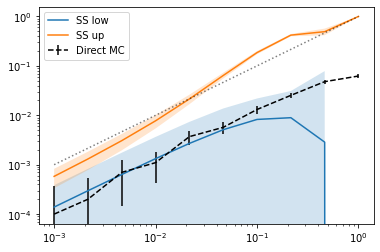

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

p = sample_range
plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

Plot product of all Aws along each path

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

err_params = {'p':1}
sam = SubsetSampler(ghz1, CHP)
partitions = sam.partitions(err_params)
counts = sam.sample(n_samples=100, chi_min=0.0001, p_max=0.1, partitions=partitions)
print(counts)

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

err_params = {'p':1}
sam = SubsetSampler(ghz1, CHP)
partitions = sam.partitions(err_params)
counts = sam.sample(n_samples=100, chi_min=0.0001, p_max=0.1, partitions=partitions)
print(counts)

{'ghz,2': {'N': 7, 'meas,0': {'N': 4, 'EXIT': {'N': 0}}, 'ghz,0': {'N': 3, 'meas,0': {'N': 3, 'EXIT': {'N': 0}}}}, 'ghz,0': {'N': 8, 'meas,0': {'N': 8, 'EXIT': {'N': 0}}}, 'ghz,4': {'N': 4, 'ghz,0': {'N': 1, 'meas,0': {'N': 1, 'EXIT': {'N': 0}}}, 'meas,0': {'N': 2, 'EXIT': {'N': 0}}, 'ghz,2': {'N': 1, 'meas,0': {'N': 1, 'EXIT': {'N': 0}}}}, 'ghz,3': {'N': 2, 'ghz,3': {'N': 1, 'meas,0': {'N': 1, 'EXIT': {'N': 0}}}, 'meas,0': {'N': 1, 'EXIT': {'N': 0}}}, 'ghz,1': {'N': 79, 'ghz,1': {'N': 5, 'ghz,4': {'N': 1, 'ghz,0': {'N': 1, 'meas,0': {'N': 1, 'EXIT': {'N': 0}}}}, 'meas,0': {'N': 3, 'EXIT': {'N': 0}}, 'ghz,0': {'N': 1, 'meas,0': {'N': 1, 'EXIT': {'N': 0}}}}, 'meas,0': {'N': 46, 'EXIT': {'N': 2}}, 'ghz,0': {'N': 28, 'meas,0': {'N': 28, 'EXIT': {'N': 0}}}}}


In [ ]:
#slow
#hide_input

sample_range = np.logspace(-3,0,20)
p_phy_per_partition = SubsetSampler.p_phy_per_partition(sample_range, err_params)

all_paths = SubsetSampler.all_paths_from_counts(counts)
Aws = []
delta = 1
for path in sorted(all_paths):
    Aw_prod_acc = 1
    path_str = ""
    for node_ss, p_fail, _ in path:
        node, w_vec_str = node_ss.split(',')
        c_hash, circuit = sam.protocol.circuit_from_node(node)
        w_vec = list(map(int, w_vec_str.split(":")))
        Aw_prod_acc *= SubsetSampler.subset_occurence(partitions[c_hash], [w_vec], p_phy_per_partition).flatten()
        path_str += ("->" if path_str else "") + node_ss
    delta -= Aw_prod_acc * (1 if len(path) < 2 else np.prod([p for _,p,_ in path[:-1]]))
    Aws.append((path_str, Aw_prod_acc))

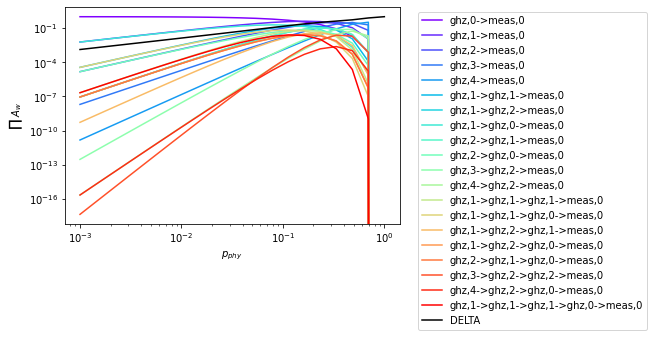

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(Aws)))
Aws.sort(key=lambda x: len(x[0]))

for i, (p_str, Aw) in enumerate(Aws):
    plt.plot(sample_range, Aw, label=p_str, color=colors[i])
    
plt.plot(sample_range, delta, label='DELTA', c='k')
plt.xlabel(r'$p_{phy}$')
plt.ylabel(r'$\prod$ $A_w$')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

Plot histogram of ERV selected subsets

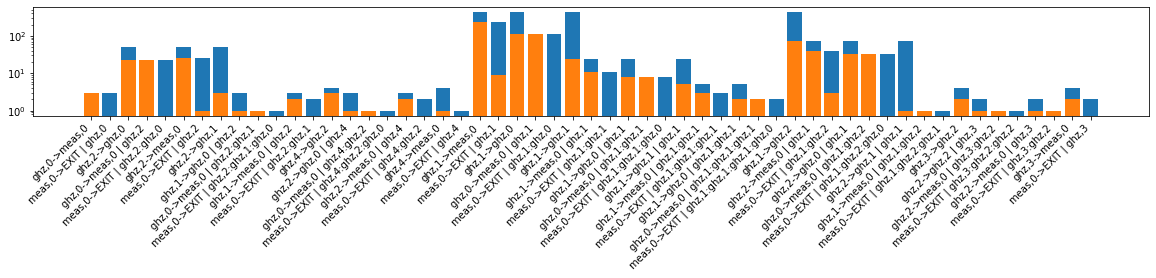

In [ ]:
#hide_input
#slow

all_paths = SubsetSampler.all_paths_from_counts(counts)
names = []
rates = []
Ns = []
for path in all_paths:
    n_path = path + [('EXIT', 0,0)]
    prev_node_ss = ""
    for i in range(len(path)):
        node_ss, p_fail, n = n_path[i]
        key = node_ss + "->" + n_path[i+1][0] + (" | " + prev_node_ss if prev_node_ss else "")
        prev_node_ss += (":" if prev_node_ss else "") + node_ss
        names.append(key)
        rates.append(p_fail * n)
        Ns.append(n)
        
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(20,2));
ax.bar(names, Ns)
ax.bar(names, rates)
ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

Histogram of failure rates of entire paths

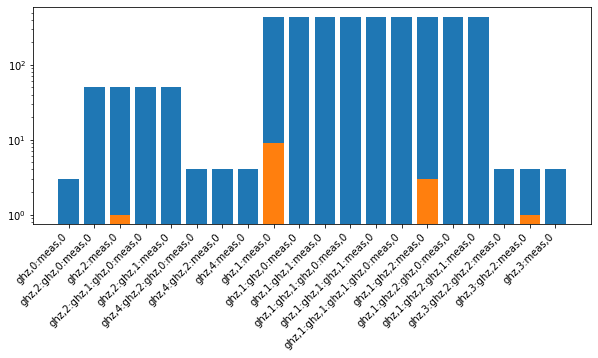

In [ ]:
#hide_input
#slow

all_paths = SubsetSampler.all_paths_from_counts(counts)
names = []
rates = []
Ns = []
for path in all_paths:
    names.append(":".join([node_ss for node_ss,_,_ in path]))
    N = path[0][2]
    Ns.append(N)
    pw = 1
    for node_ss, p_fail, _ in path:
        node, w_vec_str = node_ss.split(',')
        c_hash, circuit = sam.protocol.circuit_from_node(node)
        w_vec = list(map(int, w_vec_str.split(":")))
        Aw = SubsetSampler.subset_occurence(partitions[c_hash], [w_vec], p_phy_per_partition).flatten()
        pw *= p_fail
    rates.append(pw * N)
        
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(10,4));
ax.bar(names, Ns)
ax.bar(names, rates)
ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

# Blau: prod p[:-1]*Aw, orange: prod p*Aw